#  Decision Trees and Ensemble Learning

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Cleaning and Preparation

In [2]:
# load the dataset into pandas dataframe
df = pd.read_csv('CreditScoring.csv')

In [3]:
# let us look at the first few rows of the dataset

df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# convert the column names to lower case
df.columns = df.columns.str.lower()
df.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


In [5]:
# for the status column, convert 1 to ok, 2 to default and 0 to unknown
df.status = df.status.map({1 : "ok", 2 : "default", 0 : "unk"})
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [6]:
# convert the encoded categorical variables to their respective values
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_status = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'seperated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_status)

record_values = {
    1 : 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(record_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
# use describe to look at the numerical variables

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [9]:
# the large values 99999999.0 are actually missing values, let us deal with that

for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [10]:
# let us use describe to check the numerical columns again
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
# we have one unkown value, we can just drop that row
df = df[df.status != 'unk'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [13]:
# confirm the lenght
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [14]:
# reset the index for the train, val and test sets

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

del df_train['status']
del df_val['status']
del df_test['status']

## Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In [15]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [16]:
# create a function to fill null values in the dataset with 0 & convert the dataframe to a dictionary
def fill_null(df):
    df = df.fillna(0)
    return df.to_dict(orient='records')

In [17]:
# use pipeline to outline the steps to be performed
pipeline = Pipeline(steps=[
    ("fill", FunctionTransformer(fill_null, validate=False)),
    ("encoder", DictVectorizer(sparse = False)),
    ("model", DecisionTreeClassifier())
    ])

# fit the pipeline to the training set
pipeline.fit(df_train, y_train)

Pipeline(steps=[('fill',
                 FunctionTransformer(func=<function fill_null at 0x0000019B4401A340>)),
                ('encoder', DictVectorizer(sparse=False)),
                ('model', DecisionTreeClassifier())])

In [18]:
# test the model on the validation set
y_pred = pipeline.predict_proba(df_val)[:, 1]

In [19]:
# check the performance of the model
score = roc_auc_score(y_val, y_pred)
print(score)

0.6373725509190865


*the performance of the model is not so good, let us check the performance of the model on the training set*

In [20]:
# check the model performance on the training set
y_pred = pipeline.predict_proba(df_train)[:, 1]
score = roc_auc_score(y_train, y_pred)
print(score)

1.0


*the model scored well on the train set and did poorly on the validation set. This is known as overfitting*

Algorithm: Decision Tree Learning

1. Find the best split for the current node
2. If max depth is reached:
       stop
3. Otherwise:

       if left subset is sufficiently large and not pure:
           repeat steps 1-3 recursively for left subset

       if right subset is sufficiently large and not pure:
           repeat steps 1-3 recursively for right subset

*Best split is the split with the least impurity*

## Decision trees parameter tuning

- selecting the max_depth
- selecting min_sample_leaf

In [21]:
# tune the max_depth
depth = [1,2,3,4,5,6,10,15,20,None]

score = []
for d in depth:
    dt = pipeline.set_params(model__max_depth=d)
    dt.fit(df_train, y_train)
    y_pred = dt.predict_proba(df_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    score.append(f"depth: {d}, score: {auc:.3f}")
score

['depth: 1, score: 0.606',
 'depth: 2, score: 0.669',
 'depth: 3, score: 0.739',
 'depth: 4, score: 0.761',
 'depth: 5, score: 0.767',
 'depth: 6, score: 0.753',
 'depth: 10, score: 0.681',
 'depth: 15, score: 0.670',
 'depth: 20, score: 0.648',
 'depth: None, score: 0.668']

In [22]:
# tune the max_depth and the min_samples_leaf
scores = []
for d in [4,5,6]:
    for s in [1,2,5,6,10,14,15,16,20,200,300,500]:
            dt = pipeline.set_params(model__max_depth=d, model__min_samples_leaf=s)
            dt.fit(df_train, y_train)
            y_pred = dt.predict_proba(df_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append((d, s, auc))
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by = ['auc'], ascending=False).head()

,max_depth,min_samples_leaf,auc
31,6,16,0.790980
30,6,15,0.784856
29,6,14,0.779595
28,6,10,0.778299
32,6,20,0.774279


## Ensembles and random forest

- Board of experts
- Ensembling models
- Random forest - ensembling decison trees
- Tuning random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ("fill", FunctionTransformer(fill_null, validate=False)),
    ("encoder", DictVectorizer(sparse = False)),
    ("model", RandomForestClassifier())
    ])

In [24]:
scores = []
for n in range(10, 201, 10):
    model.set_params(model__n_estimators=n, model__random_state=1)
    model.fit(df_train, y_train)
    pred = model.predict_proba(df_val)[:, 1]
    auc = roc_auc_score(y_val, pred)
    scores.append((n, auc))
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'auc'])
df_scores.head()

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082


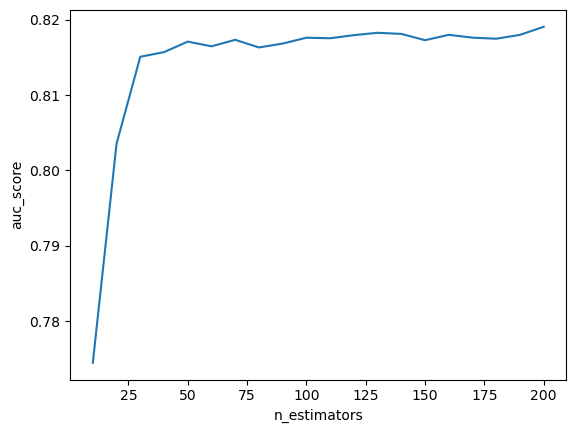

In [25]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel('n_estimators')
plt.ylabel('auc_score')
plt.show()

### Tuning the random forest

In [26]:
# we are going to tune the max_depth of the random forest
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        model.set_params(model__max_depth = d, model__n_estimators=n, model__random_state=1)
        model.fit(df_train, y_train)
        pred = model.predict_proba(df_val)[:, 1]
        auc = roc_auc_score(y_val, pred)
        scores.append((d, n, auc))
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'n_estimators', 'auc'])
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


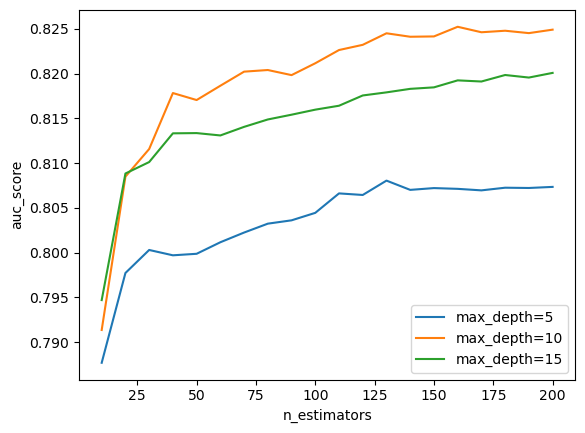

In [27]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label = f"max_depth={d}")
    plt.xlabel('n_estimators')
    plt.ylabel('auc_score')
plt.legend()
plt.show()

*from the plot above, it is evident that the best **max_depth** for our plot is **10***

In [28]:
max_depth = 10
scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        model.set_params(model__min_samples_leaf = s, 
                         model__max_depth = max_depth, 
                         model__n_estimators=n, 
                         model__random_state=1)
        model.fit(df_train, y_train)
        pred = model.predict_proba(df_val)[:, 1]
        auc = roc_auc_score(y_val, pred)
        scores.append((s, n, auc))
df_scores = pd.DataFrame(scores, columns = ['min_samples_leaf', 'n_estimators', 'auc'])
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


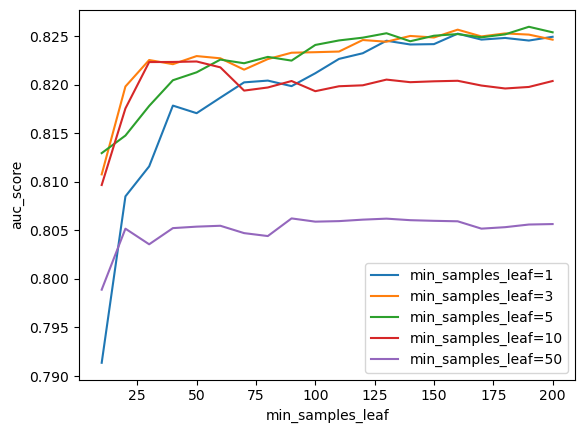

In [29]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label = f"min_samples_leaf={s}")
    plt.xlabel('min_samples_leaf')
    plt.ylabel('auc_score')
plt.legend()
plt.show()

*for our min_sample_leaf we see samples, 1, 3, 5 perform good, so let us go with **3** as our **min_samples_leaf***

In [30]:
# retrain the final model

model.set_params(model__min_samples_leaf = 3, 
                    model__max_depth = 10, 
                    model__n_estimators=100, 
                    model__random_state=1)
model.fit(df_train, y_train)

Pipeline(steps=[('fill',
                 FunctionTransformer(func=<function fill_null at 0x0000019B4401A340>)),
                ('encoder', DictVectorizer(sparse=False)),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        random_state=1))])

Other useful parameters
- `max_features` the no of features, which is choosen at random to train each decison tree
- `bootstrap` This is True by default. Bootstrap sample are used when building trees. If False, the whole dataset is used to train each tree.

## Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [32]:
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer

In [42]:
dv = DictVectorizer(sparse=False)
X_train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(X_train_dict)
X_val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(X_val_dict)

In [45]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(features))